<a href="https://colab.research.google.com/github/daphnecor/intro-to-rl/blob/main/06_random_walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 6. Temporal-Difference Learning

---

In [1]:
#@title Dependencies
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (5, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.facecolor'] = 'white'

### Example 6.2: Random Walk

We compare the prediction abilities of TD(0) and the constant-$\alpha$ MC applied to a given Markov reward process (MRP, which an MDP without actions) in Example 6.2.

---

> **TD(0) / one-step TD update rule**: [UPDATE EVERY STEP]
\begin{align*}
    V(S_t) \leftarrow V(S_t) + \alpha [R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]
\end{align*}

---

---

> **MC update rule**: [UPDATE AT END OF EPISODE]
\begin{align*}
    V(S_t) \leftarrow V(S_t) + \alpha [G_t - V(S_t)]
\end{align*}
where $G_t$ is the full episode return.

---


In [2]:
'''Set up and initialization.'''

NUM_STATES = 7 # State space
START_POS = 3 # Start in the middle
ZERO_END_POS = 0 # Terminal state with zero reward 
ONE_END_POS = 6 # Terminal state with reward of one
alpha = 0.1 # Learning rate
num_episodes_list = [0, 1, 10, 100]
true_values = np.array([1/6, 2/6, 3/6, 4/6, 5/6])

In [3]:
'''Helper functions.'''

def step(state):
    """Take a step in the MRP.
    Args:
        state (int): Position in the MRP.

    Returns:
        observation (Tuple): (next_state, reward, done)
    """
    # Determine next state (go left or right with equal probability)
    next_state = state + np.random.choice([1, -1])

    # Check if we're in a terminal state
    if next_state == ZERO_END_POS:
        return (next_state, 0, True)
    if next_state == ONE_END_POS:
        return (next_state, 1, True)
    else:
        return (next_state, 0, False)


def reset(state=START_POS, reward=0, done=False):
    """Reset the environment."""
    return state, reward, done

### Experiment 1: Create estimated value figure

In [4]:
episode_range = [0, 1, 10, 100]
td_state_values_arr = np.zeros((len(episode_range), NUM_STATES))

for idx, num_episodes in enumerate(episode_range):
        
    # Initialize V(S) arbitrarily, except V(terminal) = 0
    td_state_values = np.full(NUM_STATES, fill_value=.5)
    td_state_values[ZERO_END_POS] = 0
    td_state_values[ONE_END_POS] = 0

    ### RUN ###
    for episode_i in range(num_episodes):
        
        # Initialize state
        state, _, done = reset()
        
        while not done:
            # Observe s', r
            next_state, reward, done = step(state)

            # Update value estimate
            td_state_values[state] += alpha * (reward + td_state_values[next_state] - td_state_values[state])

            # s <-- s'
            state = next_state
    
    ###########
    
    td_state_values_arr[idx, :] = td_state_values

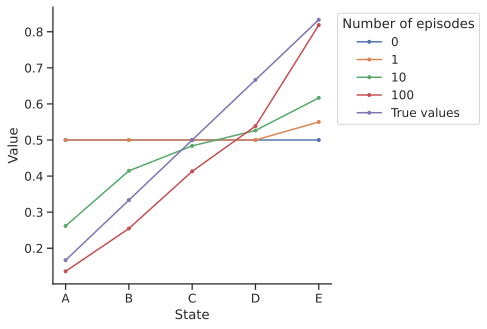

In [5]:
fig, ax = plt.subplots()
for i in range(len(episode_range)): ax.plot(td_state_values_arr[i, :][1:6], '.-', label=f'{episode_range[i]}')
ax.plot(true_values, '.-', label='True values')
ax.set_xticks(ticks=list(range(5)), labels=['A', 'B', 'C', 'D', 'E'])
plt.legend(bbox_to_anchor=(1,1), title='Number of episodes')
ax.set_xlabel('State')
ax.set_ylabel('Value')
sns.despine()

### Experiment 2: Create empirical RMS error figure

In [68]:
num_runs = 100
num_episodes = 100
alpha_range = [.05, .1, .15, .2]
td_state_values_arr = np.zeros((num_runs, num_episodes, len(alpha_range)))
mc_state_values_arr = np.zeros((num_runs, num_episodes, len(alpha_range)))

for alpha_idx, alpha in enumerate(alpha_range):
    for run_idx in trange(num_runs):
        
        # Initialize V(S) arbitrarily, except V(terminal) = 0
        td_state_values = np.full(NUM_STATES, fill_value=.5)
        td_state_values[ZERO_END_POS] = 0
        td_state_values[ONE_END_POS] = 0

        mc_state_values = td_state_values.copy()

        ### RUN ###
        for episode_idx in range(num_episodes):
            
            # Initialize state
            state, _, done = reset()
            trajectory = [(state, 0)]
            
            while not done:
                # Observe s', r
                next_state, reward, done = step(state)
                trajectory.append((state, reward))

                # Update TD(0) value estimate
                td_state_values[state] += alpha * (reward + td_state_values[next_state] - td_state_values[state])

                # s <-- s'
                state = next_state

            ###########

            # Update Monte-Carlo value estimate 
            # Note: book uses slightly different update rule
            actual_episode_return = reward # Actual outcome is the reward of the terminal state
            for (state, reward) in trajectory:
                mc_state_values[state] += alpha * (actual_episode_return - mc_state_values[state])

            # Compute RMSE over states and store
            RMSE_TD = np.sqrt(np.mean((true_values - td_state_values[1:6])**2))
            td_state_values_arr[run_idx, episode_idx, alpha_idx] = RMSE_TD     

            RMSE_MC = np.sqrt(np.mean((true_values - mc_state_values[1:6])**2))       
            mc_state_values_arr[run_idx, episode_idx, alpha_idx] = RMSE_MC


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

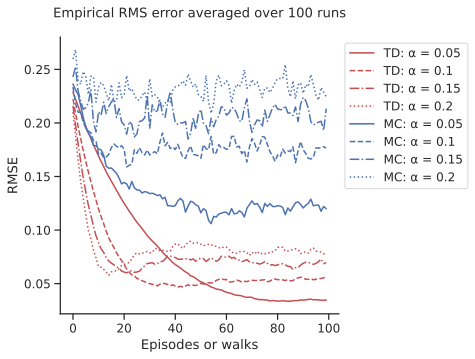

In [71]:
linestyles = ['solid', 'dashed', 'dashdot', 'dotted']

fig, ax = plt.subplots()
ax.set_title(f'Empirical RMS error averaged over {num_runs} runs', y=1.05)
for alpha_idx, alpha in enumerate(alpha_range): ax.plot(td_state_values_arr.mean(axis=0)[:, alpha_idx], 'r', ls=linestyles[alpha_idx], label=f'TD: α = {alpha}')
for alpha_idx, alpha in enumerate(alpha_range): ax.plot(mc_state_values_arr.mean(axis=0)[:, alpha_idx], 'b', ls=linestyles[alpha_idx], label=f'MC: α = {alpha}')
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Episodes or walks')
ax.set_ylabel('RMSE')
sns.despine()